# Image Analysis

## Imports

In [27]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Method definitions

In [76]:
def categorize(df, categories):
    for category in categories:
        df[category] = pd.Categorical(df[category]).codes
    return df

def numberize(df, numerics):
    for numeric in numerics:
        df[numeric] = df[numeric].astype("float")
    return df

def clean_year(year):
    return 2024 - year

# Print iterations progress
def print_progress_bar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

## Prepare data

In [29]:
df = pd.read_csv("../flatfox.csv", low_memory=False)
df.drop(df[df["offer_type"] != "RENT"].index, inplace=True)
relevant_cat = ["APARTMENT", "HOUSE"]
df.drop(df[~df["object_category"].isin(relevant_cat)].index, inplace=True)
# remove columns with wrong year
df.drop(df[df["year_built"] < 1800].index, inplace=True)
df.drop(df[df["year_built"] > 2030].index, inplace=True)
# NaN  in floors is replaced by 0
# year_built has unrealistic values (for example 19 Million)
#df['year_built'] = df['year_built'].apply(clean_year_built)

df.fillna({"year_built": df["year_built"].mean(), "floor": 0.0, "year_renovated": df["year_built"], "number_of_rooms": 0.0, "livingspace": 0.0}, inplace=True)

df.loc[df["year_renovated"] < 1800, "year_renovated"] = df["year_built"]

df["year_renovated"] = df["year_renovated"].apply(clean_year)
df["year_built"] = df["year_built"].apply(clean_year)

df.dropna(subset=["price_display"], inplace=True)

relevant_cols = ["pk", "price_display", "url", "images"]

df = df[relevant_cols]

df.head()

,pk,price_display,url,images
3,46167,610.0,/en/flat/waldstrasse-5-9008-st-gallen/46167/,"[483988, 483989, 483990, 483991, 483992, 483993]"
5,56960,2370.0,/en/flat/loft-valangines-2000-neuchatel/56960/,"[622263, 622270, 622264, 622265, 622266, 62226..."
23,97455,3104.0,/en/flat/gerechtigkeitsgasse-8-8001-zurich/97455/,"[1347873, 1347871, 1347872]"
24,97456,4246.0,/en/flat/gerechtigkeitsgasse-8-8001-zurich/97456/,"[1347880, 1347879, 1347878, 1347877, 1347881]"
25,97457,5076.0,/en/flat/gerechtigkeitsgasse-8-8001-zurich/97457/,"[1347886, 1347885, 1347887, 1347882]"


## Clustering

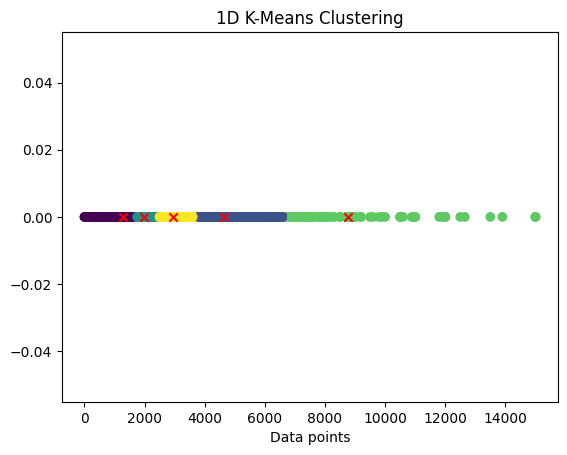

In [30]:
data = df["price_display"].values.reshape(-1, 1)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(data)
clusters = kmeans.predict(data)
centers = kmeans.cluster_centers_

# Plot the data points and cluster centers
plt.scatter(data, np.zeros_like(data), c=clusters, cmap='viridis', marker='o')
plt.scatter(centers, np.zeros_like(centers), c='red', marker='x')
plt.title('1D K-Means Clustering')
plt.xlabel('Data points')
plt.show()

## Download images

In [ ]:
QUERY = "expand=images"
BASE_URL = "https://flatfox.ch"
API_BASE = "api/v1/public-listing"

order = [0, 2, 4, 1, 3]
reverse_order = [0, 3, 1, 4, 2] # folder = reverse_order[kmeans_prediction]
pk = 0
i = 0

def get_folder(index):
    return reverse_order[index]

def get_cluster(cost):
    array = np.array([cost]).reshape(-1, 1)
    prediction = kmeans.predict(array)
    return get_folder(prediction[0])

def download_images(images, folder):
    for image in images:
        url = image["url"]
        response = requests.get(f"{BASE_URL}/{url}")
        with open(f"images/{folder}/{image['pk']}.jpg", "wb") as file:
            file.write(response.content)

for index, row in df.iterrows():
    pk = row["pk"]
    price = row["price_display"]
    
    folder = get_cluster(price)
    result = requests.get(f"{BASE_URL}/{API_BASE}/{pk}/?{QUERY}").json()
    images = result["images"]
    download_images(images, folder)
    print_progress_bar(++i, df.shape[0])
    
print(df.shape[0])

pk = 46167
result = requests.get(f"{BASE_URL}/{API_BASE}/{pk}/?{QUERY}").json()
print(result["images"][0]["url"])
print(get_cluster(3000))